In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

food_orders = pd.read_csv("food_orders_new_delhi.csv")
food_orders

,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,None,146,27,0
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,C6232,R2129,2024-01-14 05:57:00,2024-01-14 06:39:00,825,0,Digital Wallet,5% on App,165,47,50
996,997,C6797,R2742,2024-01-28 08:50:43,2024-01-28 10:10:43,1627,50,Cash on Delivery,None,110,42,0
997,998,C5926,R2837,2024-01-21 09:43:19,2024-01-21 10:44:19,553,20,Cash on Delivery,None,64,31,0
998,999,C7016,R2144,2024-01-30 22:23:38,2024-01-31 00:07:38,1414,0,Cash on Delivery,15% New User,199,34,0


In [ ]:
food_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Order ID                1000 non-null   int64 
 1   Customer ID             1000 non-null   object
 2   Restaurant ID           1000 non-null   object
 3   Order Date and Time     1000 non-null   object
 4   Delivery Date and Time  1000 non-null   object
 5   Order Value             1000 non-null   int64 
 6   Delivery Fee            1000 non-null   int64 
 7   Payment Method          1000 non-null   object
 8   Discounts and Offers    1000 non-null   object
 9   Commission Fee          1000 non-null   int64 
 10  Payment Processing Fee  1000 non-null   int64 
 11  Refunds/Chargebacks     1000 non-null   int64 
dtypes: int64(6), object(6)
memory usage: 93.9+ KB


This dataset consists of 1000 entries and 12 columns with no missing values.

#Data Cleaning

- Convert “Order Date and Time” and “Delivery Date and Time” to a datetime format.

- Convert “Discounts and Offers” to a consistent numeric value (if applicable) or calculate the discount amounts.

- Ensure all monetary values are in a suitable format for calculations.

In [ ]:
from datetime import datetime

# convert date and time columns to datetime
food_orders['Order Date and Time'] = pd.to_datetime(food_orders['Order Date and Time'])
food_orders['Delivery Date and Time'] = pd.to_datetime(food_orders['Delivery Date and Time'])

In [ ]:
# a function to extract numeric values from the 'Discounts and Offers' string
def extract_discount(discount_str):
    if 'off' in discount_str:
        # Fixed amount off
        return float(discount_str.split(' ')[0])
    elif '%%' in discount_str:
        # Percentage off
        return float(discount_str.split('%%')[0])
    else:
        # No discount
        return 0.0

# apply the function to create a new 'Discount Value' column
food_orders['Discount Percentage'] = food_orders['Discounts and Offers'].apply(lambda x: extract_discount(x))

# for percentage discounts, calculate the discount amount based on the order value
food_orders['Discount Amount'] = food_orders.apply(lambda x: (x['Order Value'] * x['Discount Percentage'] / 100)
                                                   if x['Discount Percentage'] > 1
                                                   else x['Discount Percentage'], axis=1)

# adjust 'Discount Amount' for fixed discounts directly specified in the 'Discounts and Offers' column
food_orders['Discount Amount'] = food_orders.apply(lambda x: x['Discount Amount'] if x['Discount Percentage'] <= 1
                                                   else x['Order Value'] * x['Discount Percentage'] / 100, axis=1)

In [ ]:
print(food_orders[['Order Value', 'Discounts and Offers', 'Discount Percentage', 'Discount Amount']].head(), food_orders.dtypes)

   Order Value Discounts and Offers  Discount Percentage  Discount Amount
0         1914            5% on App                  0.0              0.0
1          986                  10%                  0.0              0.0
2          937         15% New User                  0.0              0.0
3         1463                 None                  0.0              0.0
4         1992         50 off Promo                 50.0            996.0 Order ID                           int64
Customer ID                       object
Restaurant ID                     object
Order Date and Time       datetime64[ns]
Delivery Date and Time    datetime64[ns]
Order Value                        int64
Delivery Fee                       int64
Payment Method                    object
Discounts and Offers              object
Commission Fee                     int64
Payment Processing Fee             int64
Refunds/Chargebacks                int64
Discount Percentage              float64
Discount Amount        

#Cost and Profitability Analysis

For the cost analysis, we'll consider the following costs associated with each order:

- Delivery Fee: The fee charged for delivering the order.
- Payment Processing Fee: The fee for processing the payment.
- Discount Amount: The discount provided on the order.

The revenue for the platform is mainly derived from the Commission Fee. We'll calculate the net profit by subtracting the total costs (including discounts) from the revenue generated through commission fees.

In [ ]:
# calculate total costs and revenue per order
food_orders['Total Costs'] = food_orders['Delivery Fee'] + food_orders['Payment Processing Fee'] + food_orders['Discount Amount']
food_orders['Revenue'] = food_orders['Commission Fee']
food_orders['Profit'] = food_orders['Revenue'] - food_orders['Total Costs']

# aggregate data to get overall metrics
total_orders = food_orders.shape[0]
total_revenue = food_orders['Revenue'].sum()
total_costs = food_orders['Total Costs'].sum()
total_profit = food_orders['Profit'].sum()

overall_metrics = {
    "Total Orders": total_orders,
    "Total Revenue": total_revenue,
    "Total Costs": total_costs,
    "Total Profit": total_profit
}

print(overall_metrics)

{'Total Orders': 1000, 'Total Revenue': 126990, 'Total Costs': 168470.0, 'Total Profit': -41480.0}


# Profit Insights

- **Total Orders:** There were 1000 orders processed during the analyzed period. This metric indicates the volume of transactions handled by the platform.

- **Total Revenue:** The total revenue generated from these orders amounted to $126,990. This figure represents the total income earned by the platform before deducting any expenses.

- **Total Costs:** The total costs associated with processing these orders were $168,470. This includes delivery fees, payment processing fees, and any discounts provided to customers.

- **Total Profit:** The platform incurred a net loss of $41,480. This negative value indicates that the total costs exceeded the total revenue, resulting in a loss for the analyzed period.

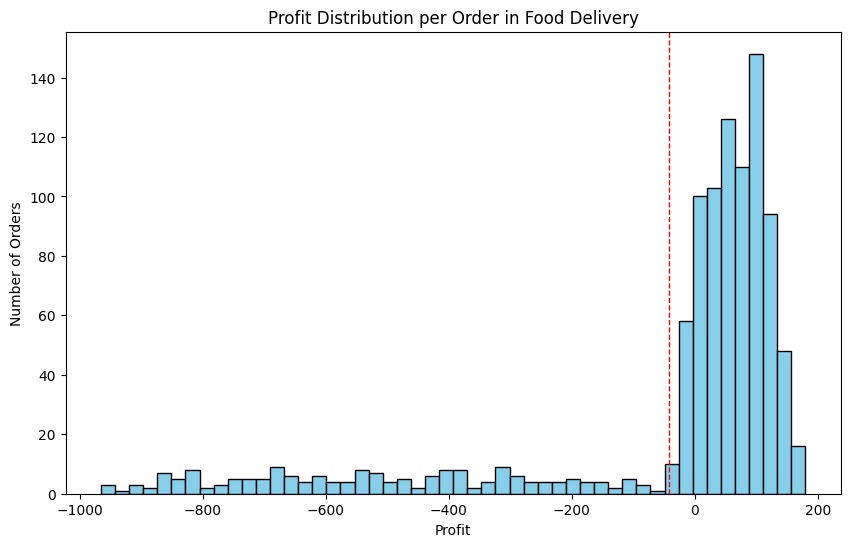

In [ ]:
import matplotlib.pyplot as plt

# histogram of profits per order
plt.figure(figsize=(10, 6))
plt.hist(food_orders['Profit'], bins=50, color='skyblue', edgecolor='black')
plt.title('Profit Distribution per Order in Food Delivery')
plt.xlabel('Profit')
plt.ylabel('Number of Orders')
plt.axvline(food_orders['Profit'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.show()

The histogram illustrates a diverse range of profit margins per order, with a significant portion of orders yielding negative profits (below 0). The red dashed line denotes the average profit, which falls into negative territory, underscoring the prevailing loss-making condition overall.

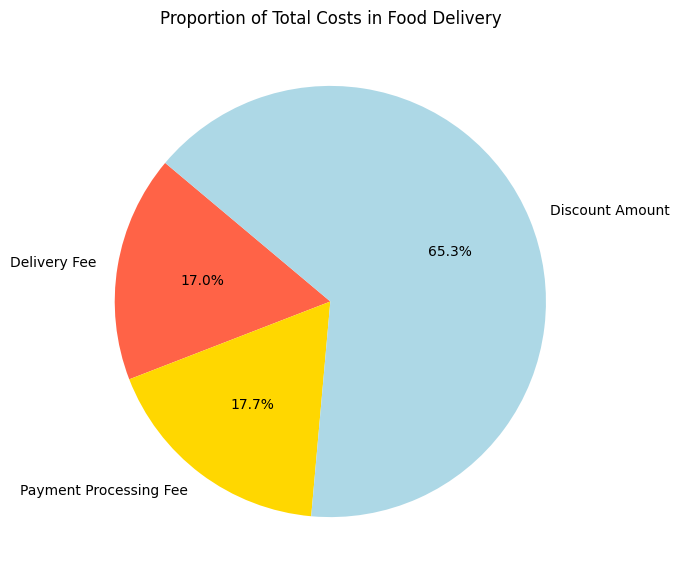

In [ ]:
# pie chart for the proportion of total costs
costs_breakdown = food_orders[['Delivery Fee', 'Payment Processing Fee', 'Discount Amount']].sum()
plt.figure(figsize=(7, 7))
plt.pie(costs_breakdown.abs(), labels=costs_breakdown.index, autopct='%1.1f%%', startangle=140, colors=['tomato', 'gold', 'lightblue'])
plt.title('Proportion of Total Costs in Food Delivery')
plt.show()

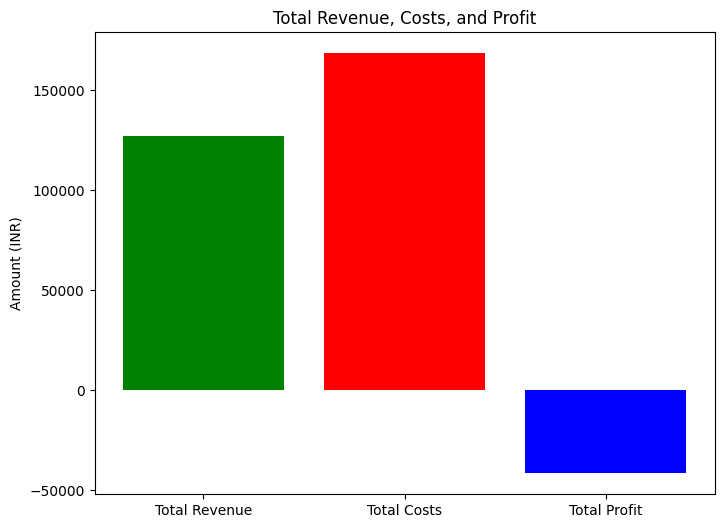

In [ ]:
# bar chart for total revenue, costs, and profit
totals = ['Total Revenue', 'Total Costs', 'Total Profit']
values = [total_revenue, total_costs, total_profit]

plt.figure(figsize=(8, 6))
plt.bar(totals, values, color=['green', 'red', 'blue'])
plt.title('Total Revenue, Costs, and Profit')
plt.ylabel('Amount (INR)')
plt.show()

# Strategy for Profit
Based on our analysis, it's evident that offering discounts on food orders has led to substantial losses. To enhance profitability, we aim to identify an optimal balance between offering discounts and charging commissions. To achieve this, we'll delve deeper into the characteristics of profitable orders to determine:

1. A new average commission percentage based on profitable orders.
2. An average discount percentage for profitable orders that still ensures profitability.

With these new averages, we can propose adjustments that not only make individual orders profitable but also have broader applicability across all orders, thereby improving overall profitability. Let's calculate:

- The average commission percentage for profitable orders.
- The average discount percentage for profitable orders.

In [ ]:
# filter the dataset for profitable orders
profitable_orders = food_orders[food_orders['Profit'] > 0]

# calculate the average commission percentage for profitable orders
profitable_orders['Commission Percentage'] = (profitable_orders['Commission Fee'] / profitable_orders['Order Value']) * 100

# calculate the average discount percentage for profitable orders
profitable_orders['Effective Discount Percentage'] = (profitable_orders['Discount Amount'] / profitable_orders['Order Value']) * 100

# calculate the new averages
new_avg_commission_percentage = profitable_orders['Commission Percentage'].mean()
new_avg_discount_percentage = profitable_orders['Effective Discount Percentage'].mean()

print(new_avg_commission_percentage, new_avg_discount_percentage)

21.94089361259831 0.5427408412483039


Based on the analysis of profitable orders, we find a new set of averages that could represent a “sweet spot” for commission and discount percentages:

New Average Commission Percentage: 21.94%


New Average Discount Percentage: 0.54%

Now, let's visualize a comparison of profitability using actual versus recommended discounts and commissions across all orders. For this, we need to:

- Calculate the profitability per order using the actual discounts and commissions already present in the dataset.

- Simulate profitability per order using the recommended discounts (0.54%) and commissions (21.94%) to see the potential impact on profitability.

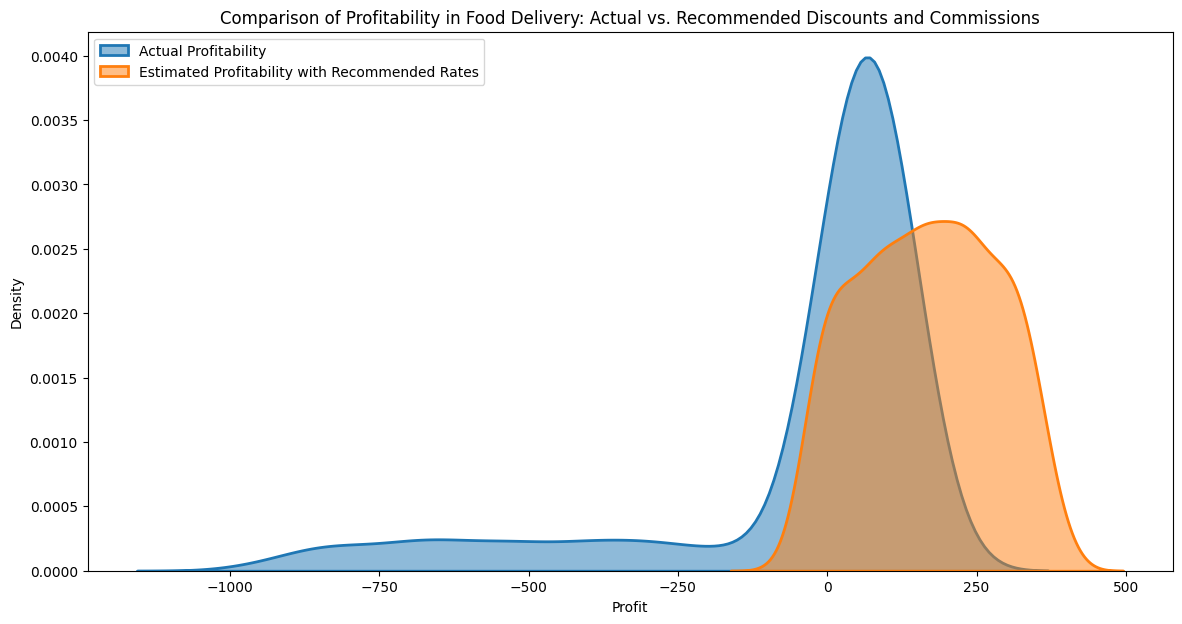

In [ ]:
# simulate profitability with recommended discounts and commissions
recommended_commission_percentage = 21.9  # 21.94%%
recommended_discount_percentage = 0.5    # 0.54%%

# calculate the simulated commission fee and discount amount using recommended percentages
food_orders['Simulated Commission Fee'] = food_orders['Order Value'] * (recommended_commission_percentage / 100)
food_orders['Simulated Discount Amount'] = food_orders['Order Value'] * (recommended_discount_percentage / 100)

# recalculate total costs and profit with simulated values
food_orders['Simulated Total Costs'] = (food_orders['Delivery Fee'] +
                                        food_orders['Payment Processing Fee'] +
                                        food_orders['Simulated Discount Amount'])

food_orders['Simulated Profit'] = (food_orders['Simulated Commission Fee'] -
                                   food_orders['Simulated Total Costs'])

# visualizing the comparison
import seaborn as sns

plt.figure(figsize=(14, 7))

# actual profitability
sns.kdeplot(food_orders['Profit'], label='Actual Profitability', fill=True, alpha=0.5, linewidth=2)

# simulated profitability
sns.kdeplot(food_orders['Simulated Profit'], label='Estimated Profitability with Recommended Rates', fill=True, alpha=0.5, linewidth=2)

plt.title('Comparison of Profitability in Food Delivery: Actual vs. Recommended Discounts and Commissions')
plt.xlabel('Profit')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.show()


The actual profitability distribution shows a mix, with a significant portion of orders resulting in losses (profit < 0) and a broad spread of profit levels for orders. The simulated scenario suggests a shift towards higher profitability per order. The distribution is more skewed towards positive profit, indicating that the recommended adjustments could lead to a higher proportion of profitable orders.